In [200]:
import numpy as np
import matplotlib.pyplot as plt
import os
from termcolor import colored
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.interpolate import CubicSpline

In [201]:
src_dir = os.path.dirname("ThrustVectorControl.ipynb")
docs_path = os.path.abspath(os.path.join(src_dir, '..', 'docs', 'data_TVC'))

if os.path.isdir(docs_path):
    print(f"{colored('Le fichier ', 'yellow')} {docs_path}, {colored('existe déja !', 'yellow')}")
else:
    os.makedirs(docs_path)

data_TVC_path = docs_path

Le fichier  c:\Users\plamb\Desktop\AeroSpaceChallenge\docs\data_TVC, existe déja !


In [202]:
# === PID ===
class PID:
    def __init__(self, Kp, Ki, Kd, max_derivative=np.inf, max_output=np.inf):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0.0
        self.previous_error = 0.0
        self.max_derivative = max_derivative
        self.max_output = max_output

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        derivative = np.clip(derivative, -self.max_derivative, self.max_derivative)
        self.previous_error = error
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        return np.clip(output, -self.max_output, self.max_output)

# === Thrust rotation ===
def rotation_matrix(theta, psi):

    # pitch
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)

    R_theta = np.array([
        [c_theta, 0, s_theta],
        [0, 1, 0],
        [-s_theta, 0, c_theta]
    ])

    # yaw
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    R_psi = np.array([
        [c_psi, -s_psi, 0],
        [s_psi, c_psi, 0],
        [0, 0, 1]
    ])

    return R_psi @ R_theta

In [203]:
# === System settings ===
J_theta = J_psi = 0.01
r = 0.5
Thrust = 50e3
tau_max = 50.0

# === Limited PID gains ===
PID_theta = PID(10.0, 1.0, 0.5, max_derivative=20.0, max_output=Thrust * 0.01)
PID_psi = PID(10.0, 1.0, 0.5, max_derivative=20.0, max_output=Thrust * 0.01)

# === Time ===
dt = 0.001
simulation_time = 6
time_array = np.arange(0, simulation_time, dt)

# === Variable instructions ===
theta_ref_log = np.radians(5.0) * np.ones_like(time_array)
psi_ref_log = np.radians(2.0) * np.ones_like(time_array)

# === Brutal instructions ===
# alpha_deg = 5
# alpha = np.radians(alpha_deg)

# theta_ref_log = np.zeros_like(time_array)
# psi_ref_log = np.zeros_like(time_array)

# theta_ref_log[time_array > 1.25] = -alpha
# theta_ref_log[time_array > 2.5]  = -alpha
# theta_ref_log[time_array > 3.75] = +alpha
# theta_ref_log[time_array > 5.0]  = +alpha

# psi_ref_log[time_array > 1.25] = -alpha
# psi_ref_log[time_array > 2.5]  = +alpha
# psi_ref_log[time_array > 3.75] = +alpha
# psi_ref_log[time_array > 5.0]  = -alpha

# === Circular path instructions ===
key_times = np.array([0.0, 1.25, 2.5, 3.75, 5.0])
theta_values_deg = 5 * np.sin(2 * np.pi * key_times / 5.0)
psi_values_deg   = 5 * np.cos(2 * np.pi * key_times / 5.0)

theta_values_rad = np.radians(theta_values_deg)
psi_values_rad = np.radians(psi_values_deg)

theta_spline = CubicSpline(key_times, theta_values_rad, bc_type='periodic')
psi_spline = CubicSpline(key_times, psi_values_rad, bc_type='periodic')

theta_ref_log = theta_spline(time_array)
psi_ref_log = psi_spline(time_array)

# === Logs ===
theta_log, psi_log = [], []
theta_dot_log, psi_dot_log = [], []
tau_theta_log, tau_psi_log = [], []
error_theta_log, error_psi_log = [], []
energy_rot_log, energy_rot_theta_log, energy_rot_psi_log = [], [], []
Tx_log, Ty_log, Tz_log = [], [], []

# === Initial states ===
theta, theta_dot = 0.0, 0.0
psi, psi_dot = 0.0, 0.0

In [204]:
for idx, t in enumerate(time_array):
    # Instructions
    theta_d = theta_ref_log[idx]
    psi_d = psi_ref_log[idx]

    # PID
    error_theta = theta_d - theta
    error_psi = psi_d - psi
    force_theta = PID_theta.compute(error_theta, dt)
    force_psi = PID_psi.compute(error_psi, dt)
    tau_theta = np.clip(r * force_theta, -tau_max, tau_max)
    tau_psi = np.clip(r * force_psi, -tau_max, tau_max)

    # Intégration RK4
    def dynamics(state, tau_theta, tau_psi):
        _, theta_dot, _, psi_dot = state
        theta_ddot = tau_theta / J_theta
        psi_ddot = tau_psi / J_psi
        return np.array([theta_dot, theta_ddot, psi_dot, psi_ddot])

    state = np.array([theta, theta_dot, psi, psi_dot])
    k1 = dynamics(state, tau_theta, tau_psi)
    k2 = dynamics(state + 0.5 * dt * k1, tau_theta, tau_psi)
    k3 = dynamics(state + 0.5 * dt * k2, tau_theta, tau_psi)
    k4 = dynamics(state + dt * k3, tau_theta, tau_psi)
    state += (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    theta, theta_dot, psi, psi_dot = state

    # Thrust
    R = rotation_matrix(theta, psi)
    T_vector = R @ np.array([Thrust, 0, 0])

    # Rotational energy
    energy_rot_theta = 0.5 * J_theta * theta_dot**2
    energy_rot_psi = 0.5 * J_psi * psi_dot**2
    energy_rot = energy_rot_theta + energy_rot_psi

    # Logs
    theta_log.append(theta)
    psi_log.append(psi)
    theta_dot_log.append(theta_dot)
    psi_dot_log.append(psi_dot)
    tau_theta_log.append(tau_theta)
    tau_psi_log.append(tau_psi)
    error_theta_log.append(error_theta)
    error_psi_log.append(error_psi)   
    energy_rot_theta_log.append(energy_rot_theta)
    energy_rot_psi_log.append(energy_rot_psi)
    energy_rot_log.append(energy_rot)
    
    Tx_log.append(T_vector[0])
    Ty_log.append(T_vector[1])
    Tz_log.append(T_vector[2])

In [205]:
theta_log = np.array(theta_log)
psi_log = np.array(psi_log)
theta_dot_log = np.array(theta_dot_log)
psi_dot_log = np.array(psi_dot_log)
theta_ref_log = np.array(theta_ref_log)
psi_ref_log = np.array(psi_ref_log)
error_theta_log = np.array(error_theta_log)
error_psi_log = np.array(error_psi_log)
tau_theta_log = np.array(tau_theta_log)
tau_psi_log = np.array(tau_psi_log)

energy_rot_theta_log = np.array(energy_rot_theta_log)
energy_rot_psi_log = np.array(energy_rot_psi_log)
energy_rot_log = np.array(energy_rot_log)

Tx_log = np.array(Tx_log)
Ty_log = np.array(Ty_log)
Tz_log = np.array(Tz_log)

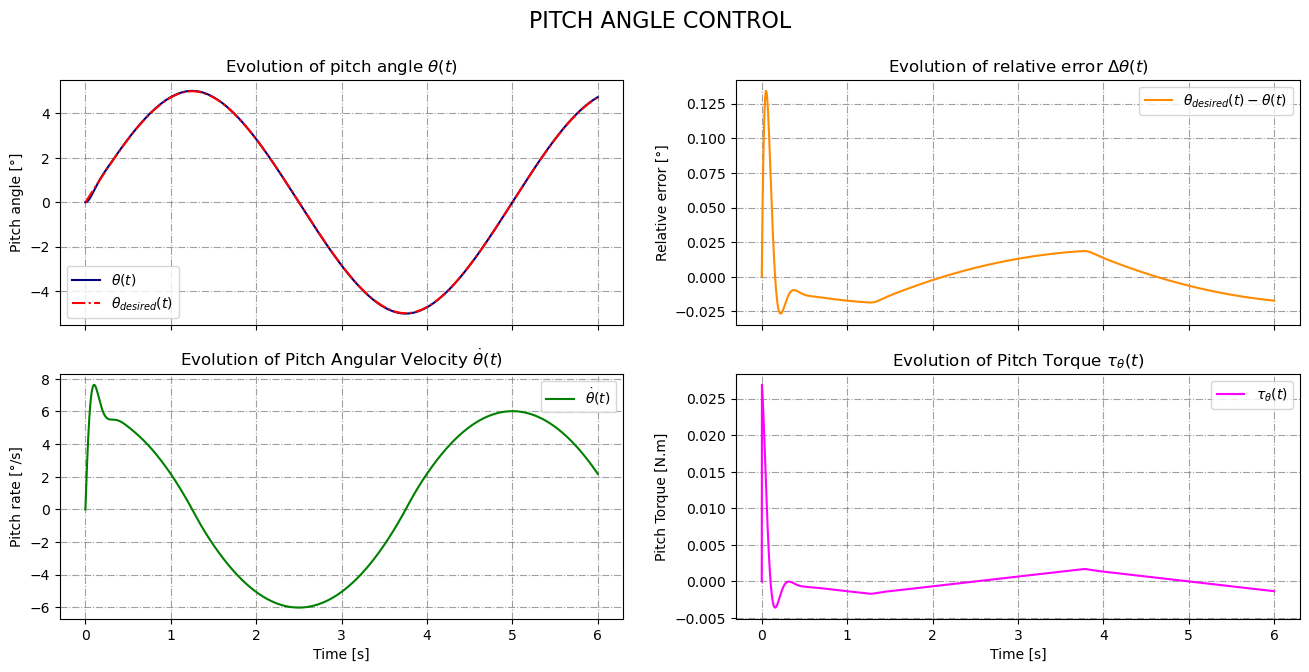

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
fig.suptitle("PITCH ANGLE CONTROL", fontsize=16)

axs[0, 0].set_title(r"Evolution of pitch angle $\theta (t)$")
axs[0, 0].plot(time_array, np.rad2deg(theta_log), color='navy', label=r'$\theta (t)$')
axs[0, 0].plot(time_array, np.rad2deg(theta_ref_log), color='red', linestyle='-.', label=r'$\theta_{desired} (t)$')
axs[0, 0].set_ylabel('Pitch angle [°]')

axs[0, 1].set_title(r"Evolution of relative error $\Delta \theta (t)$")
axs[0, 1].plot(time_array, np.rad2deg(theta_ref_log - theta_log), color='darkorange', label=r"$\theta_{desired} (t) - \theta (t)$")
axs[0, 1].set_ylabel('Relative error [°]')

axs[1, 0].set_title(r"Evolution of Pitch Angular Velocity $\dot{\theta} (t)$")
axs[1, 0].plot(time_array, np.rad2deg(theta_dot_log), color='green', label=r"$\dot{\theta} (t)$")
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Pitch rate [°/s]')

axs[1, 1].set_title(r"Evolution of Pitch Torque $\tau_\theta (t)$")
axs[1, 1].plot(time_array, tau_theta_log, color='magenta', label=r"$\tau_\theta (t)$")
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Pitch Torque [N.m]')

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend()

pitch_name = 'pitch_control.png'
plt.savefig(os.path.join(data_TVC_path, pitch_name), dpi=300)

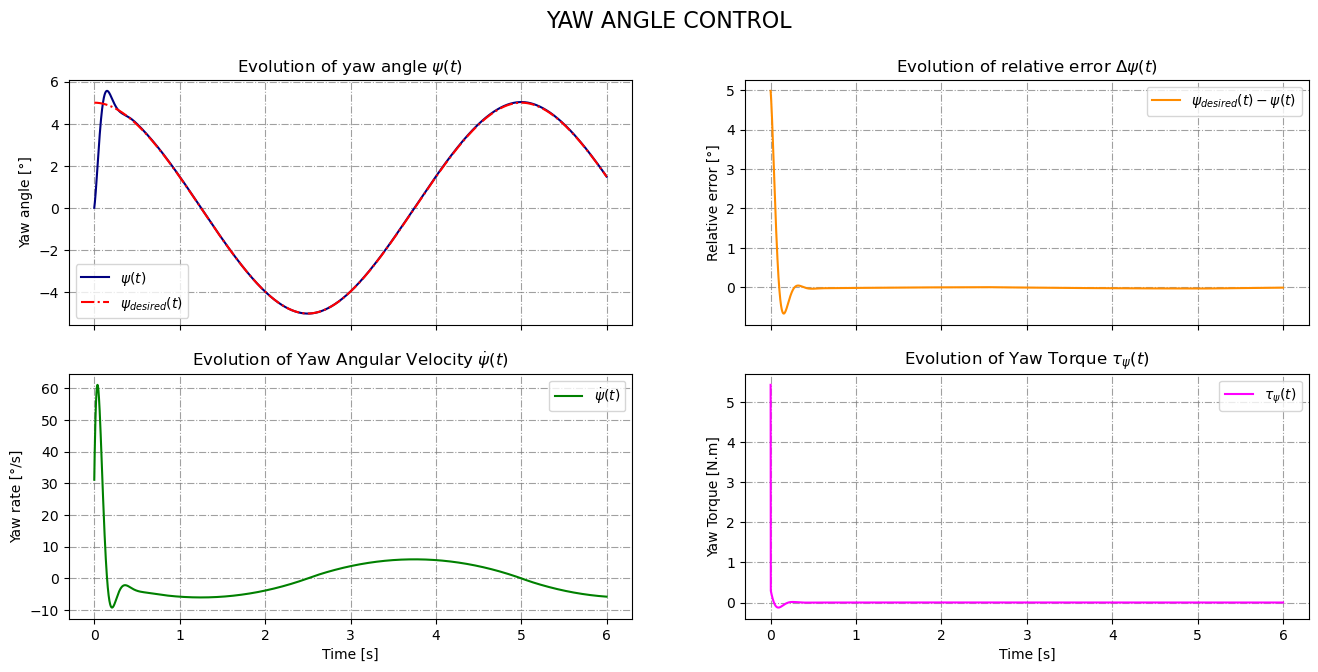

In [207]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
fig.suptitle("YAW ANGLE CONTROL", fontsize=16)

axs[0, 0].set_title(r"Evolution of yaw angle $\psi (t)$")
axs[0, 0].plot(time_array, np.rad2deg(psi_log), color='navy', label=r'$\psi (t)$')
axs[0, 0].plot(time_array, np.rad2deg(psi_ref_log), color='red', linestyle='-.', label=r'$\psi_{desired} (t)$')
axs[0, 0].set_ylabel('Yaw angle [°]')

axs[0, 1].set_title(r"Evolution of relative error $\Delta \psi (t)$")
axs[0, 1].plot(time_array, np.rad2deg(psi_ref_log - psi_log), color='darkorange', label=r"$\psi_{desired} (t) - \psi (t)$")
axs[0, 1].set_ylabel('Relative error [°]')

axs[1, 0].set_title(r"Evolution of Yaw Angular Velocity $\dot{\psi} (t)$")
axs[1, 0].plot(time_array, np.rad2deg(psi_dot_log), color='green', label=r"$\dot{\psi} (t)$")
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Yaw rate [°/s]')

axs[1, 1].set_title(r"Evolution of Yaw Torque $\tau_\psi (t)$")
axs[1, 1].plot(time_array, tau_psi_log, color='magenta', label=r"$\tau_\psi (t)$")
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Yaw Torque [N.m]')

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend()

yaw_name = 'yaw_control.png'
plt.savefig(os.path.join(data_TVC_path, yaw_name), dpi=300)

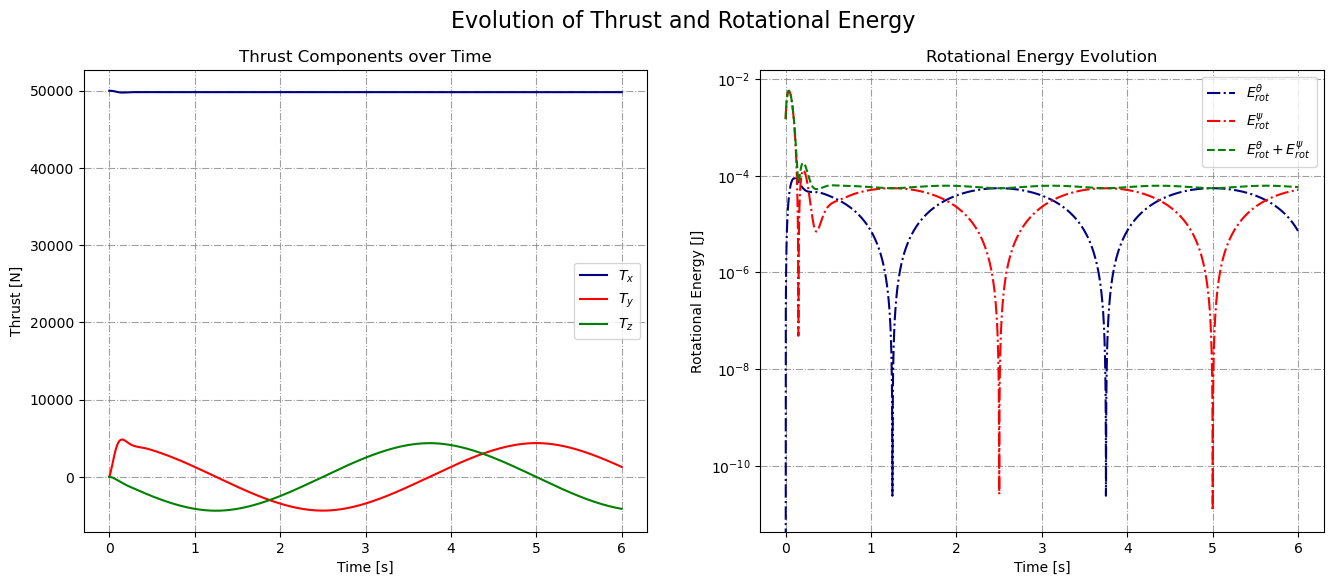

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(time_array, Tx_log, color='navy', label=r"$T_x$")
axs[0].plot(time_array, Ty_log, color='red', label=r"$T_y$")
axs[0].plot(time_array, Tz_log, color='green', label=r"$T_z$")
axs[0].set_ylabel("Thrust [N]")
axs[0].set_xlabel('Time [s]')
axs[0].set_title("Thrust Components over Time")

axs[1].plot(time_array, energy_rot_theta_log, color='navy', linestyle='-.', label=r"$E_{rot}^{\theta}$")
axs[1].plot(time_array, energy_rot_psi_log, color='red', linestyle='-.', label=r"$E_{rot}^{\psi}$")
axs[1].plot(time_array, energy_rot_log, color='green', linestyle='--', label=r"$E_{rot}^{\theta} + E_{rot}^{\psi}$")
axs[1].set_ylabel("Rotational Energy [J]")
axs[1].set_xlabel('Time [s]')
axs[1].set_title("Rotational Energy Evolution")

for ax in axs.flat:
    ax.grid(True, linestyle='-.', alpha=0.75, color='gray')
    ax.legend(loc='best')
    ax.tick_params(axis='both', which='major')

axs[0].set_yscale('linear')

axs[1].set_yscale('log')


fig.suptitle("Evolution of Thrust and Rotational Energy", fontsize=16)

thrust_energy_name = 'thrust_energy.png'
plt.savefig(os.path.join(data_TVC_path, thrust_energy_name), dpi=300)

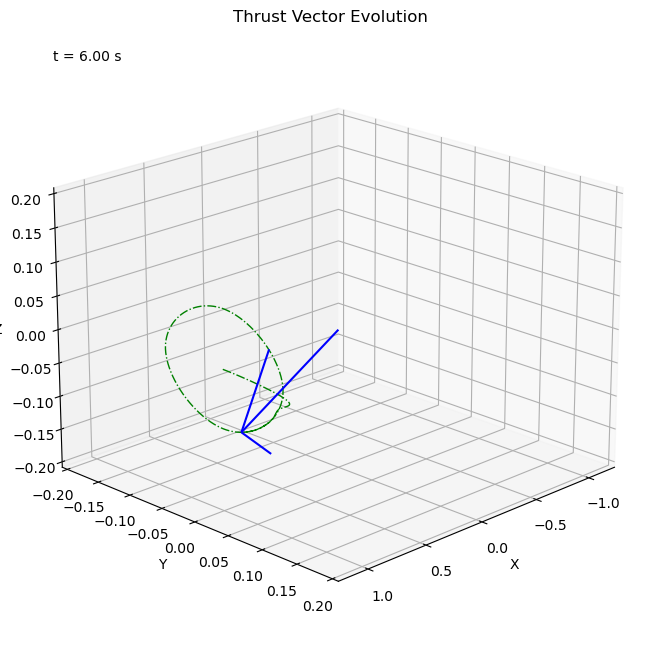

In [209]:
frame_step = 4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=45)

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([-0.2, 0.2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Thrust Vector Evolution')

quiver = ax.quiver(0, 0, 0, 0, 0, 0, color='blue')

time_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)

tip_x, tip_y, tip_z = [], [], []
tip_line, = ax.plot([], [], [], 'g-.', linewidth=1, label="Trajectoire du pic")

def update_quiver(num):
    global quiver, time_text, tip_x, tip_y, tip_z, tip_line
    quiver.remove()

    idx = num * frame_step
    if idx >= len(Tx_log):
        idx = len(Tx_log) - 1

    T_vec = np.array([Tx_log[idx], Ty_log[idx], Tz_log[idx]])
    T_vec_norm = T_vec / np.linalg.norm(T_vec) if np.linalg.norm(T_vec) != 0 else T_vec

    quiver = ax.quiver(0, 0, 0,
                       T_vec_norm[0], T_vec_norm[1], T_vec_norm[2],
                       length=1.0, normalize=True, color='blue')

    tip_pos = T_vec_norm * 1.0
    tip_x.append(tip_pos[0])
    tip_y.append(tip_pos[1])
    tip_z.append(tip_pos[2])
    tip_line.set_data(tip_x, tip_y)
    tip_line.set_3d_properties(tip_z)

    t_val = idx * dt
    time_text.set_text(f"t = {t_val:.2f} s")

    return quiver, time_text, tip_line

n_frames = len(Tx_log) // frame_step
ani = FuncAnimation(fig, update_quiver, frames=n_frames, interval=50, blit=True)

gif_path = os.path.join(data_TVC_path, 'ThrustVectorControl.gif')
ani.save(gif_path, writer=PillowWriter(fps=60, metadata={'loop': 0}))

plt.show()